# Convolutional neural network for classifying Root data fits.


Here, we define, train, and save new convolutional models as well as some 
simple model evaluation. We define hyper-parameters, number of layers, and 
training and testing datasets. 

Here, at the final layer, the network takes into account chi squared per degree of freedom.

## Load necessary packages

In [1]:
# Load some packages

# Keras packages for network
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Conv2D, Flatten
from keras.models import Model
from keras.optimizers import Adam, SGD
# For saving model
from keras.models import model_from_json
from keras.layers import concatenate, Lambda

# Some items for plotting and drawing
from keras.utils import plot_model
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
from PIL import Image
from scipy import misc
import matplotlib.pyplot as plt

# Need numpy
import numpy as np
import nn_utils as utils

%matplotlib inline

# Define image file path
im_path="/media/data/Projects/fit_pmt/images/png_fit_nn/"

Using TensorFlow backend.


## Load root fit data from file

Here, we load training data set and labels for training our CNN. 

### *Convolutional dataset consists of*
 - Linear scale png output of data points and fit lines
 - Log scale png output from the same fit
 - Fit input parameters such as high voltage, light level, minimum and maximum bounds to parameters
 - Fit output parameters such as signal mean and rms, gain measurement, chi squared per DOF, errors on parameters, etc.
 - Label (0 = bad fit, 1 = good fit)

In [2]:
# Load images
m = 100
dataset = "train"
x = utils.load_images(m=m, dataset=dataset, log_scale=False, im_path=im_path)
x_log = utils.load_images(m=m, dataset=dataset, log_scale=True, im_path=im_path)
m, h, w, c = x.shape
input_shape = h, w, c
print(str(m) + " images loaded of shape " + str(input_shape))

# Load labels
y = utils.load_labels(m=m, dataset=dataset)
print(str(y.shape[0]) + " labels loaded")

# Load fit input and output parameters 
fit_inputs, fit_outputs = utils.load_fit_results(m=m, dataset=dataset)
num_inputs, num_outputs = len(fit_inputs[0]), len(fit_outputs[1])
print(str(len(fit_inputs)) + " input arrays loaded of length " + str(num_inputs))
print(str(len(fit_outputs)) + " output arrays loaded of length " + str(num_outputs))

21 images loaded of shape (236, 348, 3)
21 labels loaded
21 input arrays loaded of length 38
21 output arrays loaded of length 20


### Load DEV set

Here, we load development set images for model evaluation.

In [6]:
# LOAD DEV SET
# Load images
m_dev = m / 5
dataset = "dev"
x_dev = utils.load_images(m=m_dev, dataset=dataset, log_scale=False, im_path=im_path)
x_log_dev = utils.load_images(m=m_dev, dataset=dataset, log_scale=True, im_path=im_path)
m_dev = x_dev.shape[0]
print(str(m_dev) + " images loaded")

# Load labels
y_dev = utils.load_labels(m=m_dev, dataset=dataset)
print(str(y_dev.shape[0]) + " labels loaded")

# Load fit input and output parameters 
fit_inputs_dev, fit_outputs_dev = utils.load_fit_results(m=m_dev, dataset=dataset)
print(str(len(fit_inputs_dev)) + " output arrays loaded")
print(str(len(fit_outputs_dev)) + " output arrays loaded")

3 images loaded
3 labels loaded
3 output arrays loaded
3 output arrays loaded


### Print an image

label: good
label: [1]

fit_inputs: [ 1.00000000e+00  1.00000000e+03  2.00000000e+02  1.90000000e+03
  4.00000000e+01  7.00000000e+00  0.00000000e+00  1.00000000e+03
  1.00000000e+00  1.00000000e+00  1.50000000e+01  5.00000000e-02
  6.33088287e+02  1.93031100e+00  5.00000000e-03  6.40000000e-01
  4.00000000e+00  1.93031100e+00  1.66667000e-01  8.33333000e-01
  1.00000000e-03 -1.00000000e+00 -1.00000000e+00 -1.00000000e+00
  5.76000000e-01 -1.00000000e+00 -1.00000000e+00  1.50000000e-01
  8.16667000e-01  3.00000000e-01 -1.00000000e+00 -1.00000000e+00
 -1.00000000e+00  7.04000000e-01 -1.00000000e+00 -1.00000000e+00
  1.83333000e-01  8.50000000e-01]

fit_outputs: [2.1430000e-03 6.3249651e+02 1.8256870e+00 1.7494000e-02 6.2118000e-01
 1.7891900e-01 8.1707200e-01 8.5000000e-05 7.6490000e-03 4.8310000e-03
 9.9100000e-04 5.7780000e-03 2.3259000e-02 3.1966000e-02 5.4620000e-03
 2.3073000e-02 3.1570030e+00 8.1513500e-01 6.4490000e-03 7.9119800e-01]


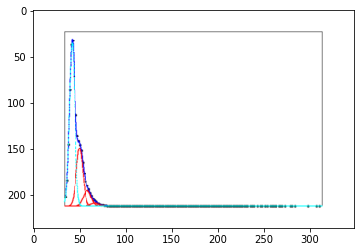

In [7]:
# Print an image
index = 17
# Choose log or linear scale
log_scale = False
this_image = x_log[index] if log_scale else x[index]
if y[index] == 1:
    print("label: good")
else:
    print("label: bad")
print("label: " + str(y[index]))
print("\nfit_inputs: " + str(fit_inputs[index]))
print("\nfit_outputs: " + str(fit_outputs[index]))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

# Define and train convolutional neural net

### *Architecture:*
 - We will actually train two conv nets in parallel side-by-side, one looking at linear scale images while the other looks at log scale images. 
 - After we put the images through the multiple convolutional layers, we will flatten them into 1D arrays and concatenate them together.
 - To this array, we will concatenate all the useful values that were input to and output from the fit algorithm.
 - We now should have all the information avaiable from the fit contained in a single array of values that we can send into a deep, fully-connected network for classification.

### *Convolutional layers:*
 - We use 3 conv layers with batch normalization, dropout, and minimal pooling.
 - In a single convolutional layer, we will scan over our images with a certain stride and a certain kernal size (with multiple filters each time). 
 - As long as our kernel size or stride is greater than 1, we will be decreasing the size of the image with each pass through a convolutional layer (we are using no padding). 
 - Through applying filters in convolution as well as using max pooling, we will end up with a very reduced representation of our image; we hope that this still contains all the information necessary to classify it as a good/bad fit.

In [8]:
# Define Conv layers
filters = []
kernels = []
strides = []
pools = []
dropouts = []

# Conv1
filters.append(32)
kernels.append(5)
strides.append(3)
pools.append(1)
dropouts.append(0.1)

# Conv2
filters.append(64)
kernels.append(7)
strides.append(2)
pools.append(1)
dropouts.append(0.1)

# Conv3
filters.append(128)
kernels.append(9)
strides.append(3)
pools.append(2)
dropouts.append(0.2)

# Define dense layers
neurons = [100, 80, 60, 40, 20, 10]

## Define keras layers (model)

Our model contains two convolutional models in parallel, each with multiple layers. We run two in parallel to utilize log scale images AND linear scale (different information present). 

After we convolve the images, we flatten them and concatenate them. We also concatenate to them a list of inputs and outputs to and from the root fit algorithm such as parameter initial condition and bounds, output parameters plus errors, and chi-squared per degree of freedom.

After concatenating these three sources of information together, we send them through some fully-connected layers to allow learning from all three sources simultaneously.

Dropout is used here for regularization.
Pooling is used here to speed up computation.
Batch normalization is used to aid in learning at deeper layers.

In [9]:
# Define input layer (RGB image matrix)
X = Input(shape=input_shape, name='Input')

# Define additional input info
X_log = Input(shape=input_shape, name='InputLog')

# Define additional input info
In_params = Input(shape=(num_inputs,), name='In_params')
Out_params = Input(shape=(num_outputs,), name='Out_params')

# Initialize activation as input
a = X
a_log = X_log
# Loop through all convolutional layers
for i in range(len(filters)):
    # Perform convolution
    a = Conv2D(filters=filters[i], kernel_size=(kernels[i], kernels[i]), strides=(strides[i], strides[i]), name=('conv' + str(i)))(a)
    a_log = Conv2D(filters=filters[i], kernel_size=(kernels[i], kernels[i]), strides=(strides[i], strides[i]), name=('conv_log' + str(i)))(a_log)
    # Normalize
    a = BatchNormalization(axis=3, name=('bn' + str(i)))(a)
    a_log = BatchNormalization(axis=3, name=('bn_log' + str(i)))(a_log)
    # Activate
    a = Activation('elu', name=('a' + str(i)))(a)
    a_log = Activation('elu', name=('a_log' + str(i)))(a_log)
    # Max-pool
    a = MaxPooling2D((pools[i], pools[i]), name=('max_pool' + str(i)))(a)
    a_log = MaxPooling2D((pools[i], pools[i]), name=('max_pool_log' + str(i)))(a_log)
    # Dropout
    a = Dropout(rate=dropouts[i])(a)
    a_log = Dropout(rate=dropouts[i])(a_log)

# Flatten output of convNet
a = Flatten()(a)
a_log = Flatten()(a_log)

# Combine log and non log outputsdef concat_vectors(input):
def concat_vectors(input):
    a = input[0]
    b = input[1]
    return concatenate([a,b], axis=1)
a_both = Lambda(concat_vectors, name='concat_images')([a, a_log])

# Concatenate and normalize input/output parameters
params = Lambda(concat_vectors, name='concat_params')([In_params, Out_params])
params = BatchNormalization(name='bn_params')(params)

# Concatenate parameters to activations
a = Lambda(concat_vectors, name='concat_all')([a_both, params])

# Loop through dense layers
for i in range(len(neurons)):
    a = Dense(units=neurons[i], activation='relu', name=('fc' + str(i)))(a)
    a = Dropout(rate=0.2)(a)
    
# Define output layer 
a = Dense(units=1, activation='sigmoid', name='sigmoid')(a)

# Make the model
model = Model(inputs=[X, X_log, In_params, Out_params], outputs=a)

##### Define optimizer, loss, and metrics. Compile model.

In [10]:
# Define optimizer
#opt = Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.001)
opt = SGD(lr=1.0, decay=1e-6, momentum=0.9, nesterov=True)
# Define loss
loss = 'mean_squared_error'
# Define metrics to use
metrics=['acc']
# Compile model
model.compile(loss=loss, optimizer='sgd', metrics=metrics)
# Print summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input (InputLayer)              (None, 236, 348, 3)  0                                            
__________________________________________________________________________________________________
InputLog (InputLayer)           (None, 236, 348, 3)  0                                            
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 78, 115, 32)  2432        Input[0][0]                      
__________________________________________________________________________________________________
conv_log0 (Conv2D)              (None, 78, 115, 32)  2432        InputLog[0][0]                   
__________________________________________________________________________________________________
bn0 (Batch

## Fit the model to the data (train)

In [11]:
# Now, fit the model to the data
histories = []
for ii in range(2):
    history = model.fit([x, x_log, fit_inputs, fit_outputs], y, validation_data=([x_dev, x_log_dev, fit_inputs_dev, fit_outputs_dev], y_dev), epochs=100, batch_size=64)
    histories.append(history)

Train on 21 samples, validate on 3 samples
Epoch 1/100
21/21 [==============================] - 5s 225ms/step - loss: 0.1261 - acc: 0.8095 - val_loss: 0.0588 - val_acc: 1.0000
Epoch 2/100
21/21 [==============================] - 0s 9ms/step - loss: 0.1266 - acc: 0.8571 - val_loss: 0.0437 - val_acc: 1.0000
Epoch 3/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0781 - acc: 0.8571 - val_loss: 0.0362 - val_acc: 1.0000
Epoch 4/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0743 - acc: 0.9048 - val_loss: 0.0318 - val_acc: 1.0000
Epoch 5/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0617 - acc: 1.0000 - val_loss: 0.0211 - val_acc: 1.0000
Epoch 6/100
21/21 [==============================] - 0s 9ms/step - loss: 0.1248 - acc: 0.8571 - val_loss: 0.0213 - val_acc: 1.0000
Epoch 7/100
21/21 [==============================] - 0s 9ms/step - loss: 0.1169 - acc: 0.8095 - val_loss: 0.0208 - val_acc: 1.0000
Epoch 8/100
21/21 [===================

Epoch 62/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0655 - acc: 0.9524 - val_loss: 6.0889e-05 - val_acc: 1.0000
Epoch 63/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0289 - acc: 1.0000 - val_loss: 5.4858e-05 - val_acc: 1.0000
Epoch 64/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0518 - acc: 1.0000 - val_loss: 4.8394e-05 - val_acc: 1.0000
Epoch 65/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0504 - acc: 1.0000 - val_loss: 4.1511e-05 - val_acc: 1.0000
Epoch 66/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0410 - acc: 0.9524 - val_loss: 4.1561e-05 - val_acc: 1.0000
Epoch 67/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0548 - acc: 1.0000 - val_loss: 3.6305e-05 - val_acc: 1.0000
Epoch 68/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0160 - acc: 0.9524 - val_loss: 3.5259e-05 - val_acc: 1.0000
Epoch 69/100
21/21 [============================

Epoch 22/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0196 - acc: 1.0000 - val_loss: 2.8493e-07 - val_acc: 1.0000
Epoch 23/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0589 - acc: 0.9524 - val_loss: 2.5134e-07 - val_acc: 1.0000
Epoch 24/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0140 - acc: 1.0000 - val_loss: 2.2015e-07 - val_acc: 1.0000
Epoch 25/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0069 - acc: 1.0000 - val_loss: 1.9827e-07 - val_acc: 1.0000
Epoch 26/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0143 - acc: 1.0000 - val_loss: 1.9127e-07 - val_acc: 1.0000
Epoch 27/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0180 - acc: 1.0000 - val_loss: 1.7330e-07 - val_acc: 1.0000
Epoch 28/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0127 - acc: 1.0000 - val_loss: 1.5421e-07 - val_acc: 1.0000
Epoch 29/100
21/21 [============================

Epoch 83/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0021 - acc: 1.0000 - val_loss: 4.2935e-09 - val_acc: 1.0000
Epoch 84/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0117 - acc: 1.0000 - val_loss: 4.1064e-09 - val_acc: 1.0000
Epoch 85/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0461 - acc: 0.8571 - val_loss: 4.5823e-09 - val_acc: 1.0000
Epoch 86/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0163 - acc: 1.0000 - val_loss: 4.1669e-09 - val_acc: 1.0000
Epoch 87/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0181 - acc: 1.0000 - val_loss: 3.8035e-09 - val_acc: 1.0000
Epoch 88/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0327 - acc: 0.9524 - val_loss: 3.1143e-09 - val_acc: 1.0000
Epoch 89/100
21/21 [==============================] - 0s 9ms/step - loss: 0.0219 - acc: 0.9524 - val_loss: 3.0284e-09 - val_acc: 1.0000
Epoch 90/100
21/21 [============================

### Print training results

dict_keys(['loss', 'val_acc', 'val_loss', 'acc'])


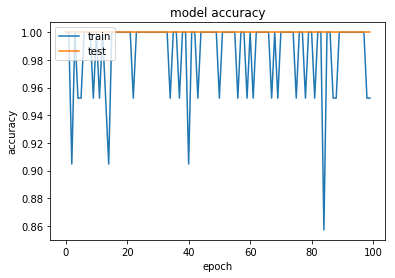

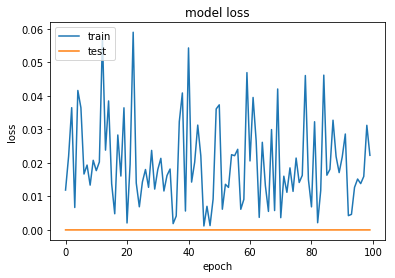

In [13]:
# List all data in history
index = 1
print(histories[index].history.keys())
# Summarize history for accuracy
plt.plot(histories[index].history['acc'])
plt.plot(histories[index].history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Summarize history for loss
plt.plot(histories[index].history['loss'])
plt.plot(histories[index].history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Additional model evaluation

In [16]:
# Evaluate model, get metrics back
stats = model.evaluate([x_dev, x_log_dev, fit_inputs_dev, fit_outputs_dev], y_dev)
# Calculate predictions vector from model
predictions = model.predict([x_dev, x_log_dev, fit_inputs_dev, fit_outputs_dev])
predictions = np.floor(predictions + 0.5)

# Get vector mask for good and bad fits and right and wrong answers
good_fits = y_dev
bad_fits = 1 - good_fits
wrong_answers = np.abs(np.subtract(predictions, good_fits))
right_answers = np.subtract(1, wrong_answers)
# Calculate true positives (tp), as well as (tn) (fp) (fn)
true_positives = np.multiply(right_answers, good_fits)
true_negatives = np.multiply(right_answers, bad_fits)
false_positives = np.multiply(wrong_answers, good_fits)
false_negatives = np.multiply(wrong_answers, bad_fits)
# Calculate additional metrics
precision = np.sum(true_positives) / np.sum(true_positives + false_positives)
recall = np.sum(true_positives) / np.sum(true_positives + false_negatives)

# Print stats
print()
print("Performance on VALIDATION set")
print(".............................")
print("Loss: " + str(stats[0]))
print("Accuracy: " + str(stats[1]))
print("Precision: " + str(precision))
print("Recall: " + str(recall))

# Print list of indices of wrong answers
bad_list = []
for i in range(m_dev):
    if wrong_answers[i] == 1:
        bad_list.append(i)
print(".............................")
print("List of indices of wrong guesses:")
print(bad_list)

3/3 [==============================] - 0s 5ms/step

Performance on VALIDATION set
.............................
Loss: 2.1703812080886564e-09
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
.............................
List of indices of wrong guesses:
[]


## Look at an image

label: [1]
prediction: [1.]
(236, 348, 3)


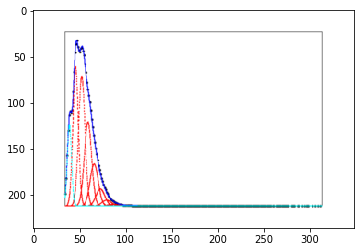

In [20]:
# Choose an index 
index = 2

# Print labels for this index
print("label: " + str(good_fits[index]))
print("prediction: " + str(predictions[index]))

# Show image
this_image = x[index]
print(str(this_image.shape))
plt.imshow(np.uint8(utils.get_printable_image(this_image)))

## Load pretrained conv model

In [47]:
# load json and create model
json_file = open('trained/conv_model_quickngood.json', 'r')
conv_model_json = json_file.read()
json_file.close()
model = model_from_json(conv_model_json)
# load weights into new model
model.load_weights("trained/conv_model_quickngood.h5")
print("Loaded model from disk")

Loaded model from disk


## Save convolutional model to disc

In [65]:
#plot_model(simple_model, to_file='simple_model.png')
#SVG(model_to_dot(simple_model).create(prog='dot', format='svg'))

# serialize model to JSON
model_json = model.to_json()
with open("trained/conv_model_chi_500epoch.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("trained/conv_model_chi_500epoch.h5")
print("Saved model to disk")

Saved model to disk
